
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Validation of the synthetic waves and level

inputs required: 
  * historical wave conditions
  * emulator output - synthetic wave conditions
  
in this notebook:
  * Validation of the extreme distributions
  * Analysis of the DWT resposible of extreme TWL events (from the historical and synthetic datasets)
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# for user inputs
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog

# for input configuration
import sys
sys.path.append('../../..')  # Appending parent directory to Python path
from input_configuration import *

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator_lim_hydrograph_days import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.outputs import Plot_LevelVariables_Histograms, Plot_PhyVariables_Histograms

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim

from teslakit.waves import Aggregate_WavesFamilies


## Database and Site parameters

In [2]:
# Teslakit database

p_data = p_data_input
db = Database(p_data)

# make a new site
db.MakeNewSite(site_name)

Teslakit Site already exists at C:/Users/fergusonpc/Teslakit-SF-Final\sites\SF_Test5


In [3]:
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)
HIST_C_h ['sea_level_pressure'] = HIST_C_h ['SLP'];
HIST_C_h ['wind_u'] = HIST_C_h ['WNDU'];
HIST_C_h ['wind_v'] = HIST_C_h ['WNDV'];
print(HIST_C_h)

# Simulation
SIM_C_h = db.Load_SIM_OFFSHORE_all(decode_times=True, use_cftime=True)
print(SIM_C_h)


<xarray.Dataset>
Dimensions:             (time: 1078249)
Coordinates:
  * time                (time) datetime64[ns] 1897-08-01 ... 2020-08-03
Data variables:
    AT                  (time) float64 ...
    AWL                 (time) float64 ...
    AWT                 (time) float64 ...
    Dir                 (time) float64 ...
    DWT                 (time) float64 ...
    Hs                  (time) float64 ...
    level               (time) float64 ...
    max_storms          (time) bool ...
    MJO                 (time) float64 ...
    MMSL                (time) float64 ...
    sea_Dir             (time) float64 ...
    sea_Hs              (time) float64 ...
    sea_Tp              (time) float64 ...
    SLP                 (time) float64 ...
    SS                  (time) float64 ...
    swell_1_Dir         (time) float64 ...
    swell_1_Hs          (time) float64 ...
    swell_1_Tp          (time) float64 ...
    swell_2_Dir         (time) float64 ...
    swell_2_Hs          (tim

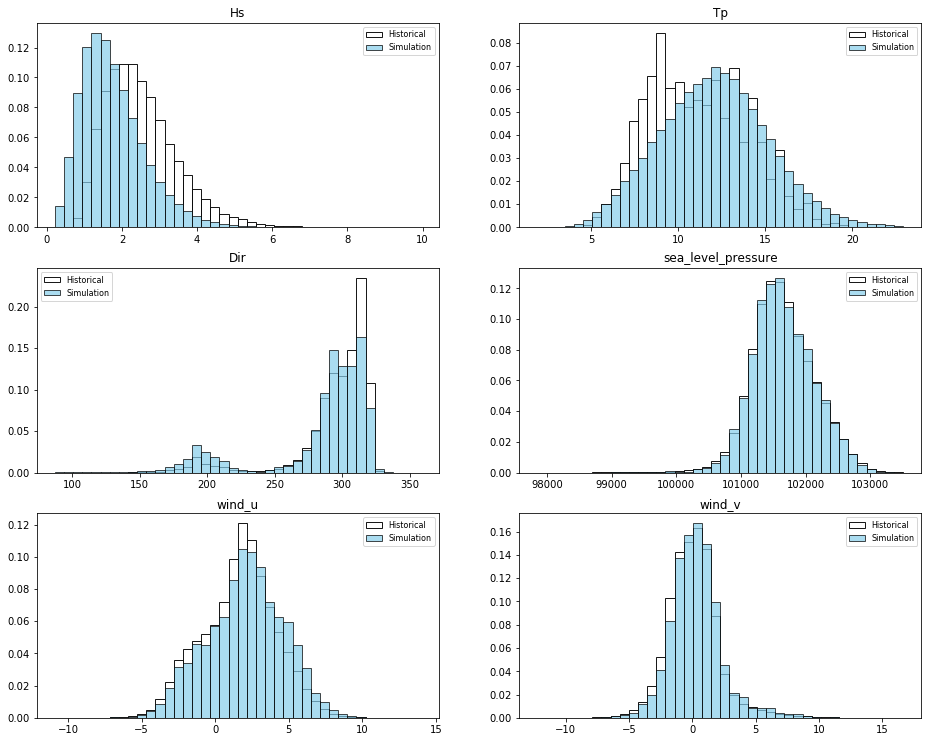

In [4]:
# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_PhyVariables_Histograms(HIST_C_h, SIM_C_h.sel(n_sim = 0));

In [5]:
# load historical waves families
WVS = db.Load_WAVES_hist()
print (WVS)

WVS = WVS.drop(['Hs', 'Tp', 'Dir', 'TC_category'])
# print (WVS)

# add extra var
ss = db.Load_storm_surge()
xtr_var= ss.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['SS'] = xtr_var.ss

# add extra var
PRMSL_L101 = db.Load_sea_level_pressure()
xtr_var= PRMSL_L101.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['SLP'] = xtr_var.PRMSL_L101

# add extra var
U_GRD_L103 = db.Load_wind_u()
xtr_var= U_GRD_L103.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['WNDU'] = xtr_var.U_GRD_L103

# add extra var
V_GRD_L103 = db.Load_wind_v()
xtr_var= V_GRD_L103.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['WNDV'] = xtr_var.V_GRD_L103

# aggregate waves families
WVS_agr = Aggregate_WavesFamilies(WVS, 'max_energy')

WVS = xr.merge([WVS, WVS_agr])

WVS ['sea_level_pressure'] = WVS ['SLP'];
WVS ['wind_u'] = WVS ['WNDU'];
WVS ['wind_v'] = WVS ['WNDV'];


<xarray.Dataset>
Dimensions:      (time: 350640)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    TC_category  (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1


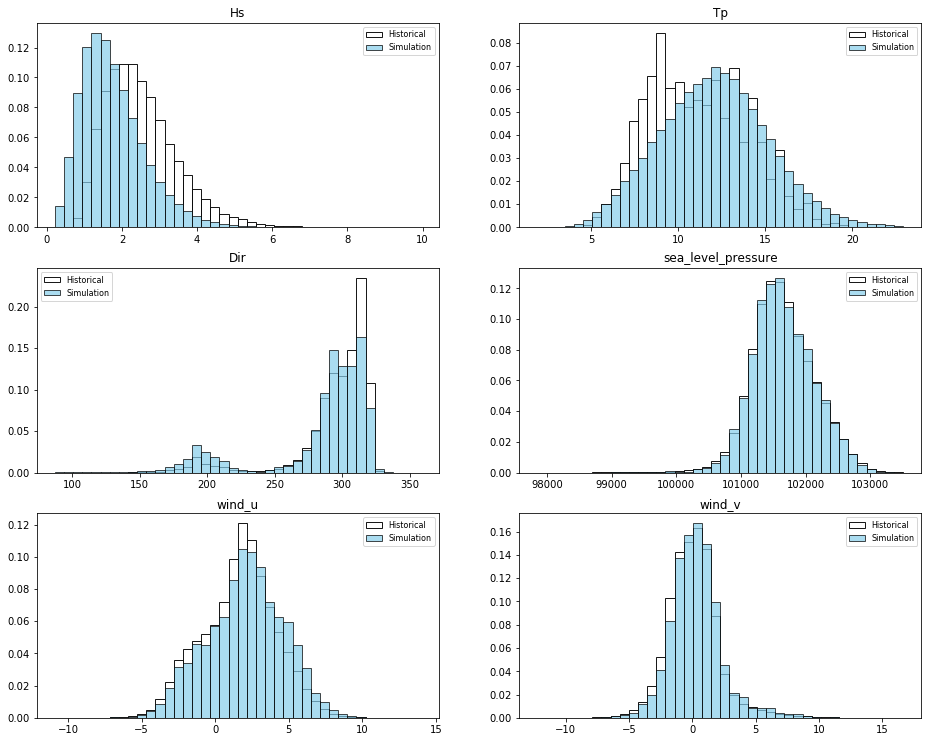

In [6]:
# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_PhyVariables_Histograms(WVS, SIM_C_h.sel(n_sim = 0));

In [7]:
# load historical waves families
WVS = db.Load_WAVES_hist()
print (WVS)

WVS = WVS.drop(['TC_category'])
# print (WVS)

# add extra var
ss = db.Load_storm_surge()
xtr_var= ss.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['SS'] = xtr_var.ss

# add extra var
PRMSL_L101 = db.Load_sea_level_pressure()
xtr_var= PRMSL_L101.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['SLP'] = xtr_var.PRMSL_L101

# add extra var
U_GRD_L103 = db.Load_wind_u()
xtr_var= U_GRD_L103.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['WNDU'] = xtr_var.U_GRD_L103

# add extra var
V_GRD_L103 = db.Load_wind_v()
xtr_var= V_GRD_L103.resample(time='1h').pad().sel(time=slice(WVS.time[0], WVS.time[-1]))
WVS['WNDV'] = xtr_var.V_GRD_L103

WVS ['sea_level_pressure'] = WVS ['SLP'];
WVS ['wind_u'] = WVS ['WNDU'];
WVS ['wind_v'] = WVS ['WNDV'];


<xarray.Dataset>
Dimensions:      (time: 350640)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    TC_category  (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1


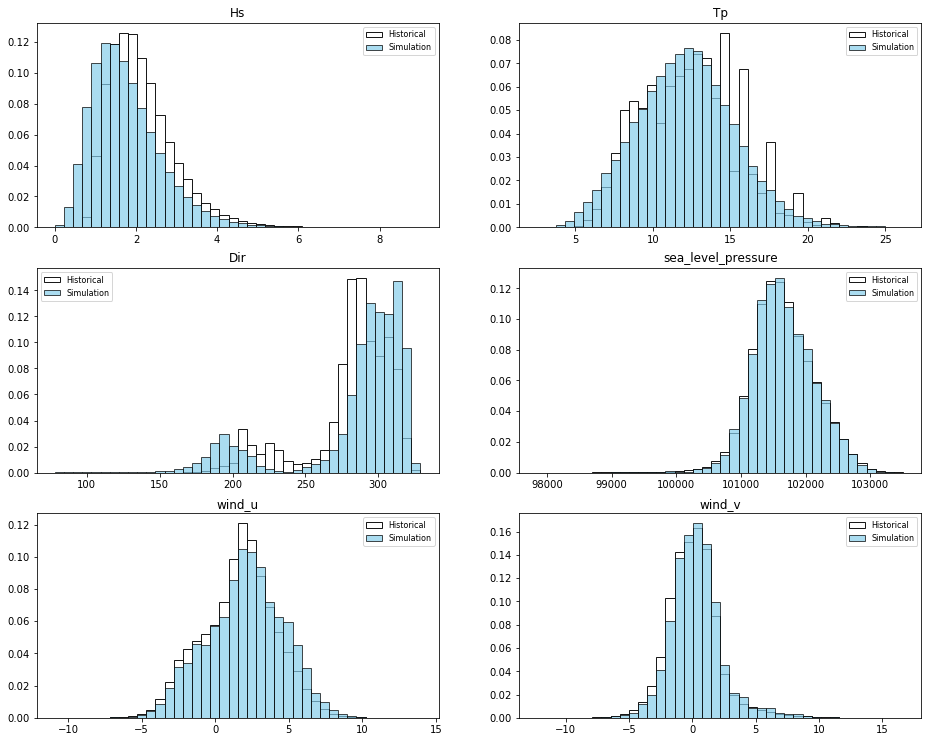

In [8]:
# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_PhyVariables_Histograms(WVS, SIM_C_h.sel(n_sim = 0));

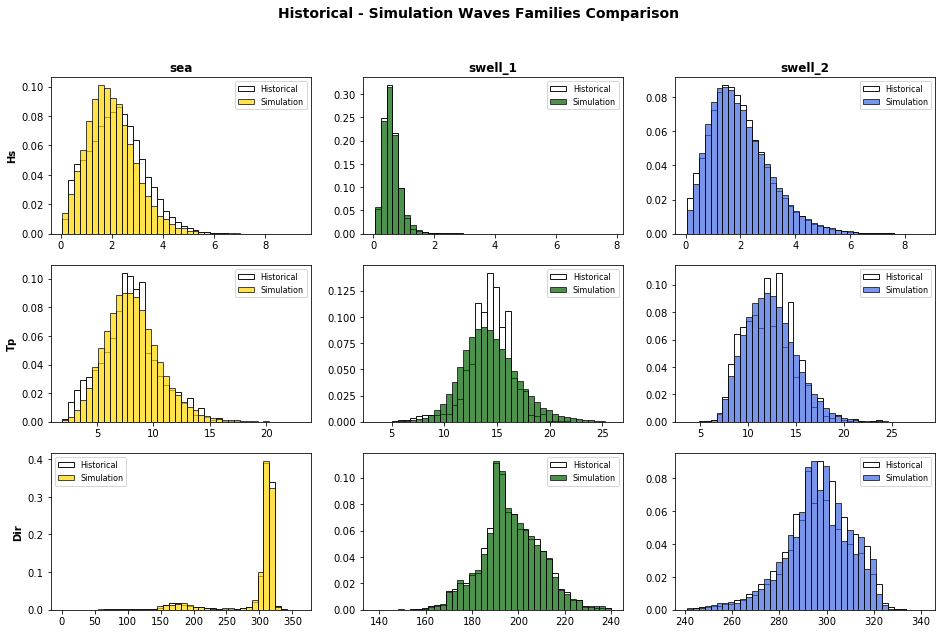

In [9]:
# Plot simulated waves parameters distribution. The 9 wave components are hourly rather than intradaily in nb12
Plot_Waves_Histogram_FitSim(HIST_C_h, SIM_C_h.sel(n_sim = 0));

In [10]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})



## AWL - Annual Maxima Calculation

In [11]:
# Historical AWL Annual Maxima

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


In [12]:
# Simulation AWL Annual Maxima

# calculate AWL annual maxima dataset
sim_AMax = SIM_C_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')



## AWL - Annual Maxima Return Period

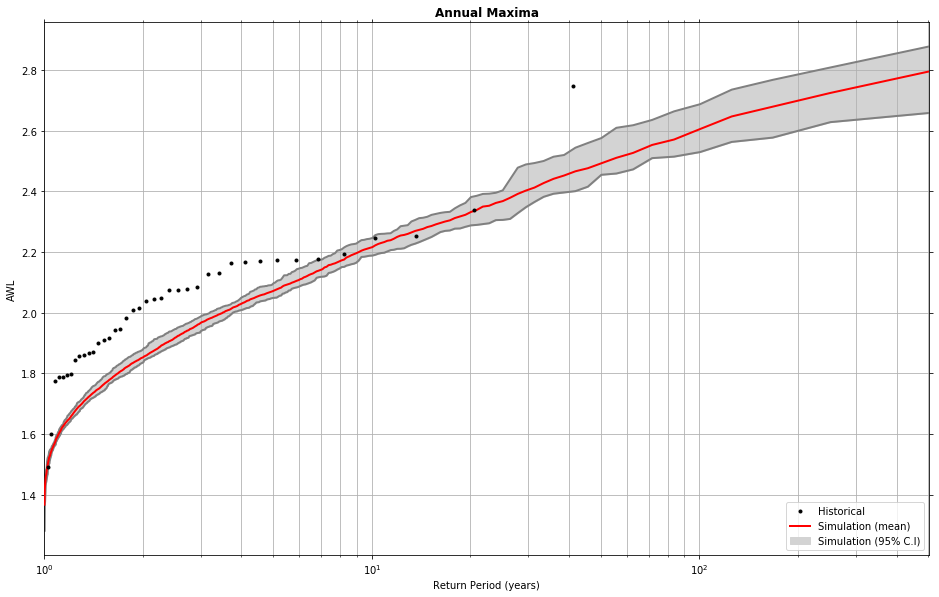

In [13]:
# AWL Annual Maxima Return Period (historical vs. simulations)

Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());


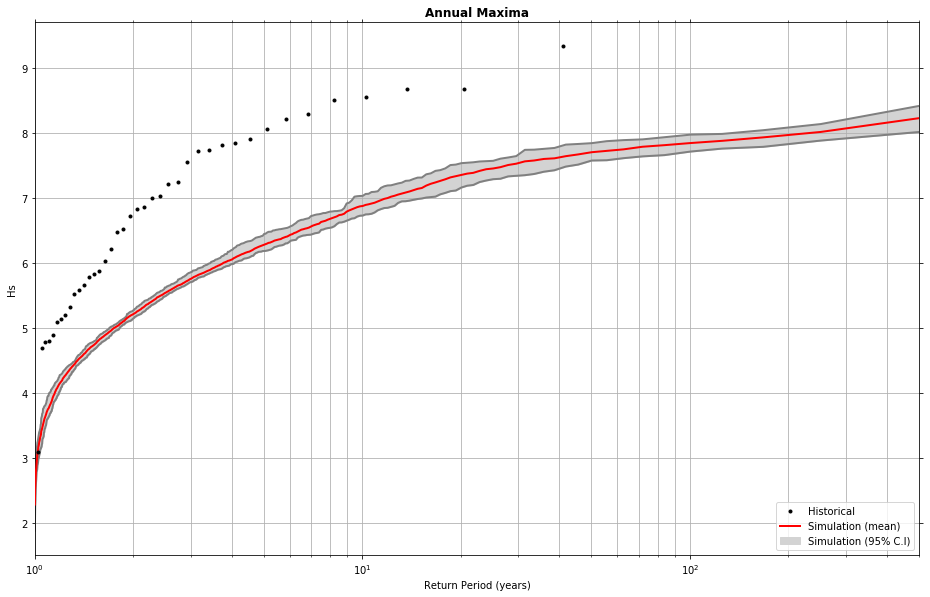

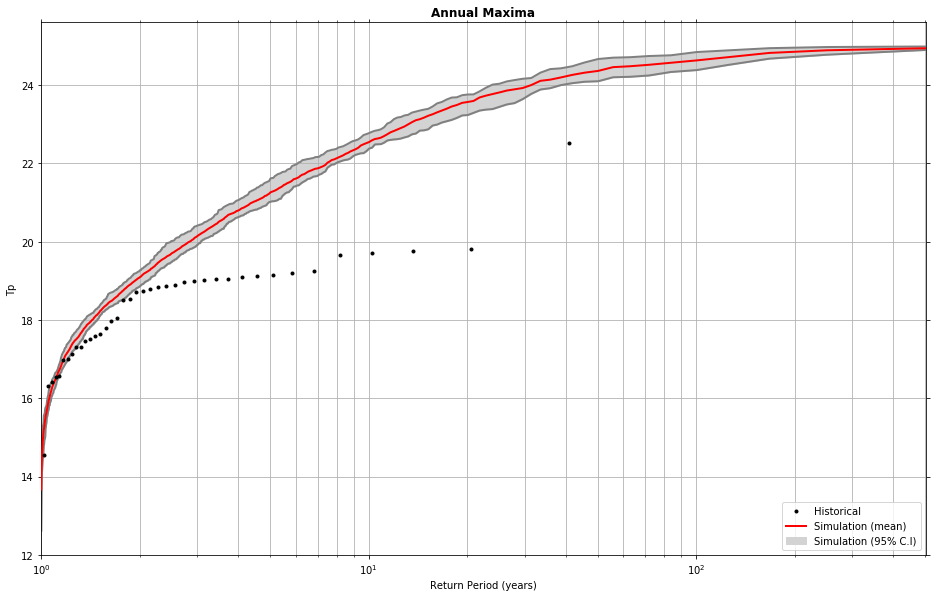

In [14]:
# Hs and Tp Return Period (historical vs. simulations) at AWL Annual Maxima

# Hs at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());

# Tp at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());



## AWL - Annual Maxima Probabilistic Plots

In [15]:
# Probabilistic plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
sim_AMax_n = sim_AMax.sel(n_sim=0)


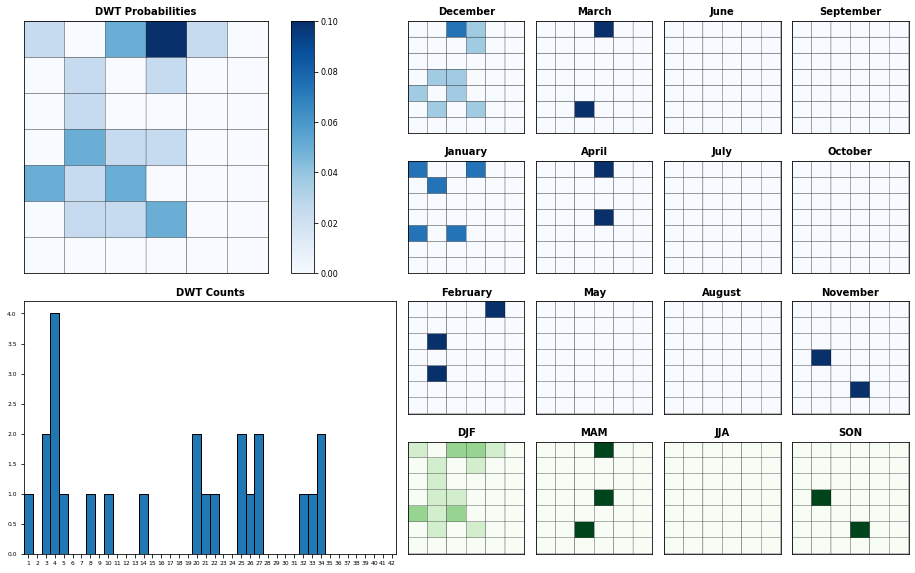

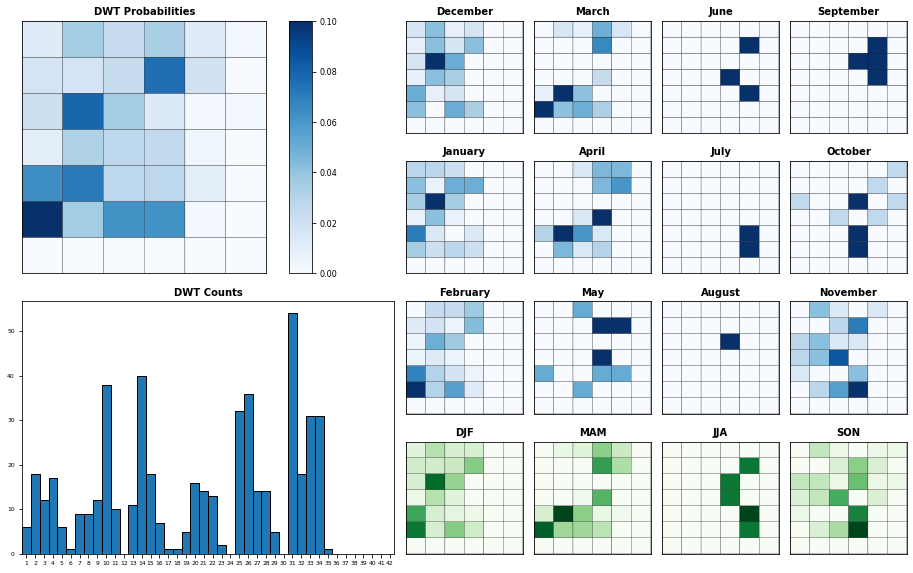

In [16]:
# Plot Annual Maxima DWT probabilities by month

# Historical
Plot_DWTs_Probs(hist_AMax['DWT'].values, hist_AMax.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(sim_AMax_n['DWT'].values, sim_AMax_n.time.values, n_clusters_DWT);


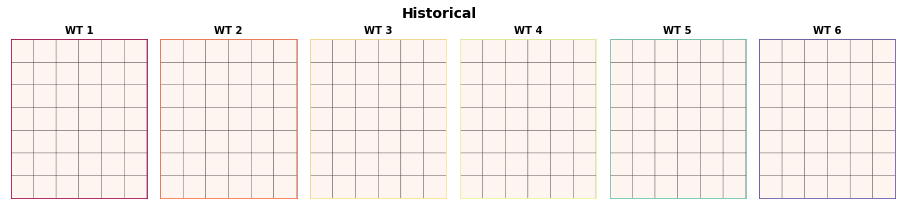

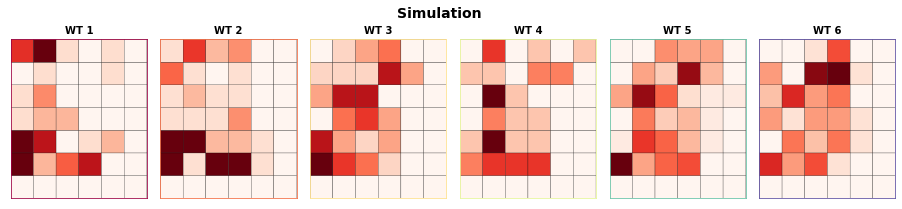

In [17]:
# Plot Annual Maxima AWTs/DWTs Probabilities 

# Historical
Plot_Probs_WT_WT(
    hist_AMax['AWT'].values - 1, hist_AMax['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Historical',
);

# Simulation 
Plot_Probs_WT_WT(
    sim_AMax_n['AWT'].values[:] - 1, sim_AMax_n['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);



## AWL - Peaks Over Threshold Calculation

In [18]:
# POT  plots parameters

n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters

# Select one simulation DWTs - WAVEs simulation
n_sim = 0
SIM_C_h_n = SIM_C_h.sel(n_sim=0)


# TODO: update POT to work with hourly data
_, ix = np.unique(SIM_C_h_n['time'], return_index=True)  
SIM_C_h_n = SIM_C_h_n.isel(time=ix)

# Parse data to daily 
HIST_C_d = xds_reindex_daily(HIST_C_nonan)  # TODO: check possible bug if this puts NAN inside AWL data
SIM_C_d_n = xds_reindex_daily(SIM_C_h_n)


In [19]:
# Get independent event peaks (99 percentile)

# Historical
times_POT = POT(HIST_C_d.isel(time=slice(1,-1)), 'AWL', 99).time  # TODO: check possible awl nan bug
hist_POT = HIST_C_d.sel(time = times_POT)

# Simulation
times_POT = POT(SIM_C_d_n, 'AWL', 99).time
sim_POT = SIM_C_d_n.sel(time = times_POT)



## AWL - Peaks Over Threshold Probabilistic Plots

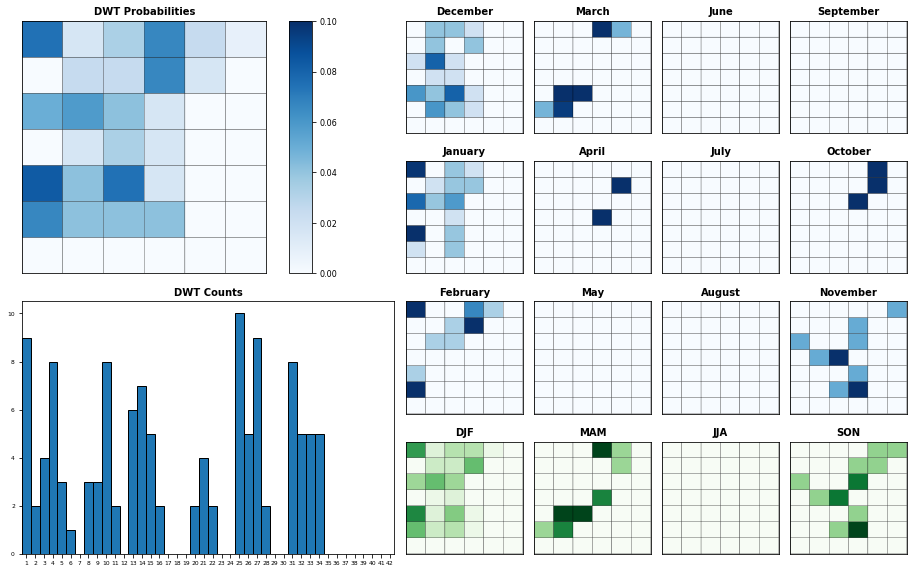

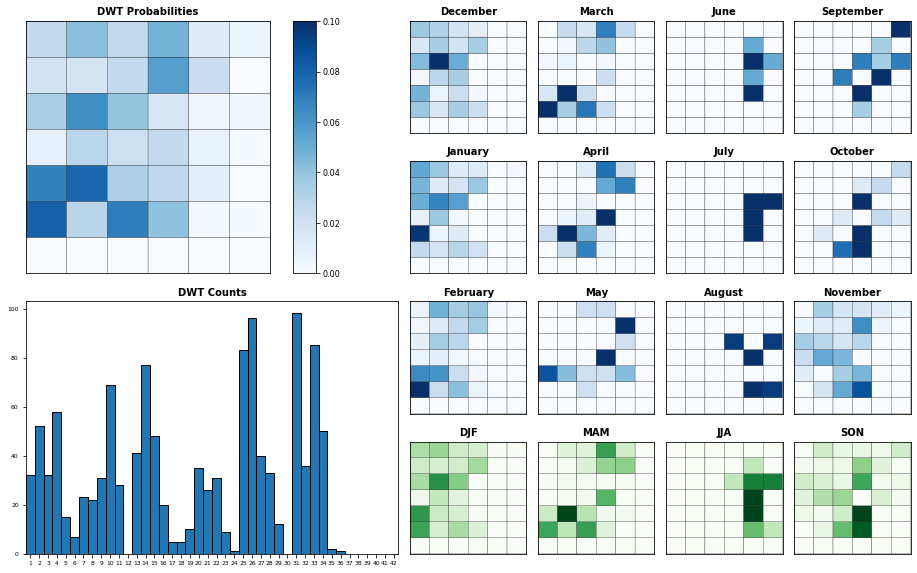

In [20]:
# Plot Peaks Over Threshold DWT probabilities by month

# Historical
Plot_DWTs_Probs(hist_POT['DWT'].values, hist_POT.time.values, n_clusters_DWT);

# Simulation
Plot_DWTs_Probs(sim_POT['DWT'].values, sim_POT.time.values, n_clusters_DWT);


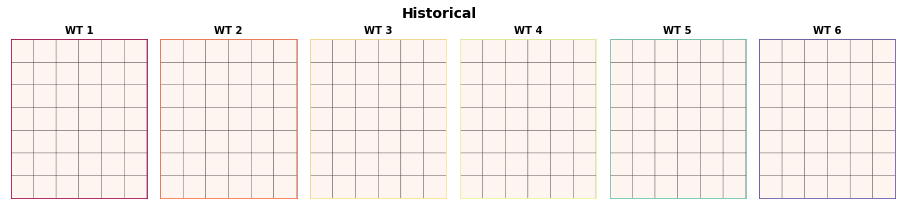

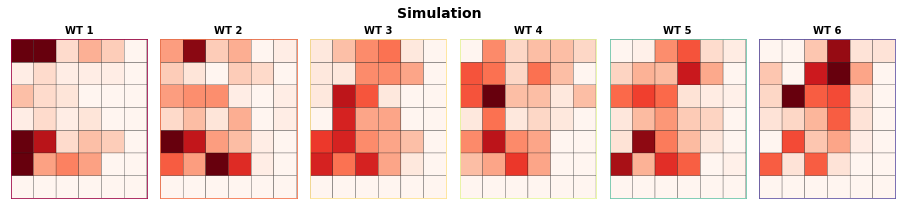

In [21]:
# Plot Peaks Over Threshold AWTs/DWTs Probabilities 

# Historical
Plot_Probs_WT_WT(
    hist_POT['AWT'].values - 1, hist_POT['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Historical',
);

# Simulation 
Plot_Probs_WT_WT(
    sim_POT['AWT'].values[:] - 1, sim_POT['DWT'].values[:] - 1, 
    n_clusters_AWT, n_clusters_DWT, wt_colors=True, ttl = 'Simulation',
);



## Level Variables (level, AT, MMSL, TWL) - Histograms

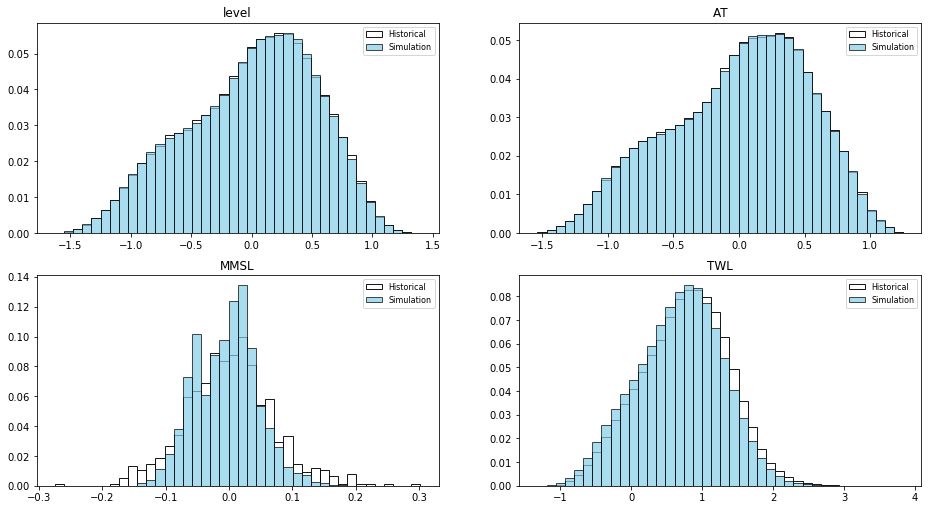

In [22]:

# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_LevelVariables_Histograms(HIST_C_h, SIM_C_h.sel(n_sim = 0));



## TWL - Annual Maxima

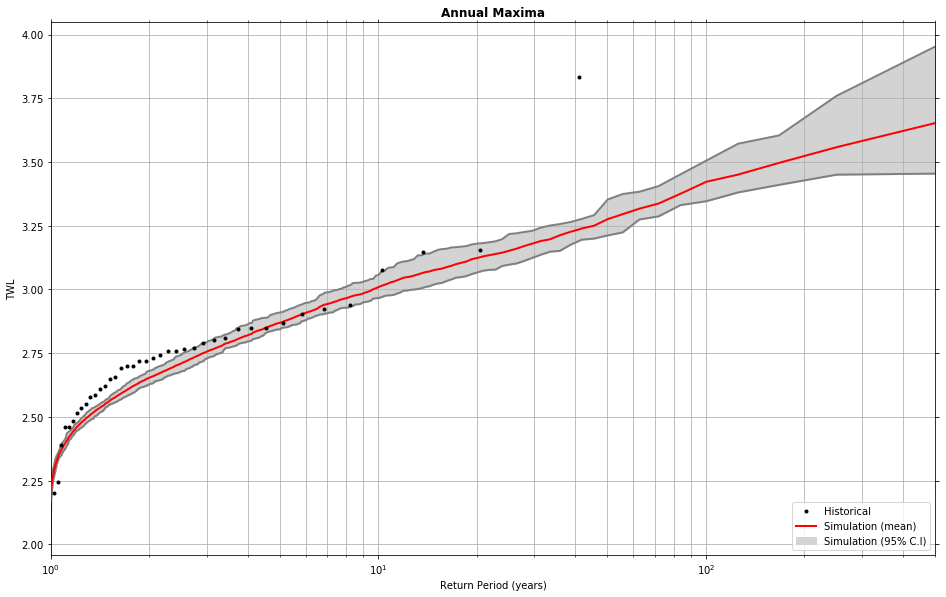

In [23]:
# Plot TWL annual maxima

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_C_h['TWL'].groupby('time.year').max(dim='time')
sim_A = SIM_C_h['TWL'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());
